In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [2]:
!wget -q https://dlcdn.apache.org/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz

!tar xf spark-3.4.0-bin-hadoop3.tgz

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = '/content/spark-3.4.0-bin-hadoop3'

In [4]:
# Install library for finding Spark
!pip install -q findspark
# Import the libary
import findspark
# Initiate findspark
findspark.init()
# Check the location for Spark
findspark.find()

'/content/spark-3.4.0-bin-hadoop3'

In [5]:
# Import SparkSession
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark

In [6]:
# Import a Spark function from library
from pyspark.sql.functions import col

In [7]:
from google.colab import files
upload = files.upload()

Saving Online Retail.csv to Online Retail.csv


In [8]:
# Reading csv file
data = spark.read.csv("Online Retail.csv", inferSchema=True, header = True)

In [9]:
data = data.toPandas()

In [10]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [ ]:
len(data)

541909

In [ ]:
import pandas as pd

# Delete rows starting with "C"
data = data[~data['InvoiceNo'].str.startswith('C')]

# Delete rows starting with "A"
data = data[~data['InvoiceNo'].str.startswith('A')]

In [ ]:
len(data)

532618

In [ ]:
# List of values to be removed
values_to_remove = ["AMAZONFEE", "B", "BANK CHARGES", "C2", "CRUK", "D", "DOT", "gift_0001_10",
                    "gift_0001_20", "gift_0001_30", "gift_0001_40", "gift_0001_50", "M", "PADS",
                    "POST", "S"]

# Remove rows matching the specified values
data = data[~data['StockCode'].isin(values_to_remove)]

In [ ]:
import pandas as pd

# Create a new column as the key by combining 'InvoiceNo' and 'StockCode'
data['Key'] = data['InvoiceNo'].astype(str) + '_' + data['StockCode'].astype(str)

# Remove duplicates based on the key
data = data.drop_duplicates(subset='Key')

# Remove the 'Key' column
data = data.drop('Key', axis=1)

In [ ]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [ ]:
len(data)

519755

In [ ]:
columns_to_drop = ['Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']
deleted_cols_data = data
# Drop the specified columns
deleted_cols_data = deleted_cols_data.drop(columns_to_drop, axis=1)

In [ ]:
deleted_cols_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 519755 entries, 0 to 541908
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   InvoiceNo  519755 non-null  object
 1   StockCode  519755 non-null  object
dtypes: object(2)
memory usage: 11.9+ MB


In [ ]:
deleted_cols_data[deleted_cols_data['StockCode']=='10002'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73 entries, 31 to 171573
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   InvoiceNo  73 non-null     object
 1   StockCode  73 non-null     object
dtypes: object(2)
memory usage: 1.7+ KB


In [ ]:
# Perform the left join
df_left_join = pd.merge(deleted_cols_data, deleted_cols_data, on='InvoiceNo', how='left', suffixes=('', '_y'))
#df_left_join = df_left_join[df_left_join['StockCode'] != df_left_join['StockCode_y']]


In [ ]:
df_left_join.head()

# df_left_join[df_left_join['InvoiceNo'] == '551429']['InvoiceNo'].nunique()


,InvoiceNo,StockCode,StockCode_y
0,536365,85123A,85123A
1,536365,85123A,71053
2,536365,85123A,84406B
3,536365,85123A,84029G
4,536365,85123A,84029E


In [ ]:
combinations = df_left_join.groupby(['StockCode', 'StockCode_y']).agg(num_invoices=('InvoiceNo', 'nunique')).reset_index()

In [ ]:
combinations.head()

,StockCode,StockCode_y,num_invoices
0,10002,10002,73
1,10002,10120,2
2,10002,10123C,1
3,10002,10125,5
4,10002,10133,3


In [ ]:
df_left_join[df_left_join['StockCode']=='10002']['InvoiceNo'].unique()

array(['536370', '536382', '536756', '536863', '536865', '536876',
       '537047', '537227', '537240', '537638', '537642', '537666',
       '537770', '537823', '538069', '538071', '538086', '538093',
       '538167', '538196', '538255', '538524', '538566', '538593',
       '538853', '538890', '539322', '539434', '539451', '539595',
       '540239', '540277', '540418', '540732', '540798', '541094',
       '541248', '541262', '541277', '541491', '541518', '541592',
       '541615', '541631', '541698', '541849', '541878', '542096',
       '542610', '542629', '542735', '543179', '543806', '544201',
       '544205', '544278', '544634', '544935', '545316', '545637',
       '545717', '546649', '546790', '547063', '547223', '547729',
       '548286', '548606', '548702', '548714', '550272', '550452',
       '551429'], dtype=object)

In [ ]:
# deleted_cols_data[deleted_cols_data['StockCode'] == '10002']

In [ ]:
combinations_2 = df_left_join.groupby(['StockCode']).agg(num_invoices=('InvoiceNo', 'nunique')).reset_index()

In [ ]:
combinations_2.head()

,StockCode,num_invoices
0,10002,73
1,10080,24
2,10120,29
3,10123C,4
4,10123G,1


In [ ]:
merged_combinations = combinations.merge(combinations_2, on='StockCode', how='left')

In [ ]:
merged_combinations.head()

,StockCode,StockCode_y,num_invoices_x,num_invoices_y
0,10002,10002,73,73
1,10002,10120,2,73
2,10002,10123C,1,73
3,10002,10125,5,73
4,10002,10133,3,73


In [ ]:
combinations_2.rename(columns={'StockCode': 'StockCode_y'}, inplace=True)
merged_combinations_2 = merged_combinations.merge(combinations_2, on = "StockCode_y", how='left')

In [ ]:
merged_combinations_2.head()

,StockCode,StockCode_y,num_invoices_x,num_invoices_y,num_invoices
0,10002,10002,73,73,73
1,10002,10120,2,73,29
2,10002,10123C,1,73,4
3,10002,10125,5,73,91
4,10002,10133,3,73,197


In [ ]:
merged_combinations_2['total_transactions_xy'] = merged_combinations_2['num_invoices_y'] + merged_combinations_2['num_invoices'] - merged_combinations_2['num_invoices_x']

In [ ]:
merged_combinations_2.head()

,StockCode,StockCode_y,num_invoices_x,num_invoices_y,num_invoices,total_transactions_xy
0,10002,10002,73,73,73,73
1,10002,10120,2,73,29,100
2,10002,10123C,1,73,4,76
3,10002,10125,5,73,91,159
4,10002,10133,3,73,197,267


In [ ]:
merged_combinations_2['num_invoices_y'] = merged_combinations_2['num_invoices_y'] - merged_combinations_2['num_invoices_x']
merged_combinations_2['num_invoices'] = merged_combinations_2['num_invoices'] - merged_combinations_2['num_invoices_x']

In [ ]:
merged_combinations_2.head()

,StockCode,StockCode_y,num_invoices_x,num_invoices_y,num_invoices,total_transactions_xy
0,10002,10002,73,0,0,73
1,10002,10120,2,71,27,100
2,10002,10123C,1,72,3,76
3,10002,10125,5,68,86,159
4,10002,10133,3,70,194,267


In [ ]:
txns = deleted_cols_data['InvoiceNo'].nunique()
txns

21874

In [ ]:
merged_combinations_2['total_transactions_xy'] = txns- merged_combinations_2['total_transactions_xy']

In [ ]:
merged_combinations_2.head()

,StockCode,StockCode_y,A,B,C,D
0,10002,10002,73,0,0,21801
1,10002,10120,2,71,27,21774
2,10002,10123C,1,72,3,21798
3,10002,10125,5,68,86,21715
4,10002,10133,3,70,194,21607


In [ ]:
merged_combinations_2.rename(columns={'num_invoices_x': 'A', 'num_invoices_y': 'B', 'num_invoices': 'C', 'total_transactions_xy': 'D'}, inplace=True)

In [ ]:
# merged_combinations_2.head(30)

In [ ]:
# Define the Yule's coefficient function
def yules_coefficient(a, b, c, d):
  numerator = (a * d) - (b * c)
  denominator = (a * d) + (b * c)
  if denominator != 0:
    return numerator / denominator
  else:
    return 0

In [ ]:
a = merged_combinations_2['A']*merged_combinations_2['D']
b = merged_combinations_2['B']*merged_combinations_2['C']
merged_combinations_2['YuleCoefficient'] = (a - b) / (a + b)

In [ ]:
merged_combinations_2.head()

,StockCode,StockCode_y,A,B,C,D,YuleCoefficient
0,10002,10002,73,0,0,21801,1.000000
1,10002,10120,2,71,27,21774,0.915671
2,10002,10123C,1,72,3,21798,0.980376
3,10002,10125,5,68,86,21715,0.897783
4,10002,10133,3,70,194,21607,0.653576


In [ ]:
clustering_dataset_stage_1 = merged_combinations_2[['StockCode', 'StockCode_y', 'YuleCoefficient']]

In [ ]:
clustering_dataset_stage_1.head()

,StockCode,StockCode_y,YuleCoefficient
0,10002,10002,1.000000
1,10002,10120,0.915671
2,10002,10123C,0.980376
3,10002,10125,0.897783
4,10002,10133,0.653576


In [ ]:
clustering_dataset_stage_1['YuleCoefficient'].max()

1.0

In [ ]:
clustering_dataset_stage_1['YuleCoefficient'].min()

-0.8931764267141806

In [ ]:
## Rescaling Yule's Coefficient
## Yule's Q is rescaled to be between 0-2 instead with 0 becoming the perfect association and 2 being a negative association.
# The reason for doing this is that clustering algorithms work off a notion of 'distance' between elements and won't work with negative values for distance.
clustering_dataset_stage_1['YuleCoefficient'] = 1- clustering_dataset_stage_1['YuleCoefficient']

<ipython-input-61-00844c45ee22>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clustering_dataset_stage_1['YuleCoefficient'] = 1- clustering_dataset_stage_1['YuleCoefficient']


In [ ]:
clustering_dataset_stage_1['YuleCoefficient'].min()

0.0

In [ ]:
clustering_dataset_stage_1['YuleCoefficient'].max()

1.8931764267141806

In [ ]:
# Transpose the DataFrame by 'StockCode_y'
transposed_df = clustering_dataset_stage_1.pivot(index='StockCode', columns='StockCode_y', values='YuleCoefficient')

In [ ]:
transposed_df.head()

StockCode_y,10002,10080,10120,10123C,10123G,10124A,10124G,10125,10133,10134,...,DCGS0069,DCGS0070,DCGS0071,DCGS0072,DCGS0073,DCGS0074,DCGS0076,DCGSSBOY,DCGSSGIRL,m
StockCode,,,,,,,,,,,,,,,,,,,,,
10002,0.000000,NaN,0.084329,0.019624,NaN,NaN,NaN,0.102217,0.346424,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.006584,NaN,NaN,NaN
10080,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.344622,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10120,0.084329,NaN,0.000000,0.007662,NaN,NaN,NaN,0.207621,0.404466,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10123C,0.019624,NaN,0.007662,0.000000,NaN,NaN,NaN,0.024490,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10123G,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
transposed_df = transposed_df.fillna(2)
## 2 indicates negative association

In [ ]:
transposed_df.head()

StockCode_y,10002,10080,10120,10123C,10123G,10124A,10124G,10125,10133,10134,...,DCGS0069,DCGS0070,DCGS0071,DCGS0072,DCGS0073,DCGS0074,DCGS0076,DCGSSBOY,DCGSSGIRL,m
StockCode,,,,,,,,,,,,,,,,,,,,,
10002,0.000000,2.0,0.084329,0.019624,2.0,2.0,2.0,0.102217,0.346424,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,0.006584,2.0,2.0,2.0
10080,2.000000,0.0,2.000000,2.000000,2.0,2.0,2.0,2.000000,0.344622,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.000000,2.0,2.0,2.0
10120,0.084329,2.0,0.000000,0.007662,2.0,2.0,2.0,0.207621,0.404466,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.000000,2.0,2.0,2.0
10123C,0.019624,2.0,0.007662,0.000000,2.0,2.0,2.0,0.024490,2.000000,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.000000,2.0,2.0,2.0
10123G,2.000000,2.0,2.000000,2.000000,0.0,2.0,2.0,2.000000,2.000000,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.000000,2.0,2.0,2.0


In [ ]:
transposed_df = transposed_df.rename(columns=lambda x: x.strip(), index=lambda x: x.strip())

In [ ]:
transposed_df = transposed_df.rename_axis(None, axis='columns')

In [ ]:
transposed_df.head()

,10002,10080,10120,10123C,10123G,10124A,10124G,10125,10133,10134,...,DCGS0069,DCGS0070,DCGS0071,DCGS0072,DCGS0073,DCGS0074,DCGS0076,DCGSSBOY,DCGSSGIRL,m
StockCode,,,,,,,,,,,,,,,,,,,,,
10002,0.000000,2.0,0.084329,0.019624,2.0,2.0,2.0,0.102217,0.346424,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,0.006584,2.0,2.0,2.0
10080,2.000000,0.0,2.000000,2.000000,2.0,2.0,2.0,2.000000,0.344622,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.000000,2.0,2.0,2.0
10120,0.084329,2.0,0.000000,0.007662,2.0,2.0,2.0,0.207621,0.404466,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.000000,2.0,2.0,2.0
10123C,0.019624,2.0,0.007662,0.000000,2.0,2.0,2.0,0.024490,2.000000,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.000000,2.0,2.0,2.0
10123G,2.000000,2.0,2.000000,2.000000,0.0,2.0,2.0,2.000000,2.000000,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.000000,2.0,2.0,2.0


In [ ]:
transposed_df_copy = transposed_df

In [ ]:
transposed_df_copy.reset_index(inplace = True)

In [ ]:
transposed_df_copy.head()

,StockCode,10002,10080,10120,10123C,10123G,10124A,10124G,10125,10133,...,DCGS0069,DCGS0070,DCGS0071,DCGS0072,DCGS0073,DCGS0074,DCGS0076,DCGSSBOY,DCGSSGIRL,m
0,10002,0.000000,2.0,0.084329,0.019624,2.0,2.0,2.0,0.102217,0.346424,...,2.0,2.0,2.0,2.0,2.0,2.0,0.006584,2.0,2.0,2.0
1,10080,2.000000,0.0,2.000000,2.000000,2.0,2.0,2.0,2.000000,0.344622,...,2.0,2.0,2.0,2.0,2.0,2.0,2.000000,2.0,2.0,2.0
2,10120,0.084329,2.0,0.000000,0.007662,2.0,2.0,2.0,0.207621,0.404466,...,2.0,2.0,2.0,2.0,2.0,2.0,2.000000,2.0,2.0,2.0
3,10123C,0.019624,2.0,0.007662,0.000000,2.0,2.0,2.0,0.024490,2.000000,...,2.0,2.0,2.0,2.0,2.0,2.0,2.000000,2.0,2.0,2.0
4,10123G,2.000000,2.0,2.000000,2.000000,0.0,2.0,2.0,2.000000,2.000000,...,2.0,2.0,2.0,2.0,2.0,2.0,2.000000,2.0,2.0,2.0


In [ ]:
from sklearn.cluster import AgglomerativeClustering

cluster_df = pd.DataFrame()

for i in range(2, 11):
    # Perform hierarchical clustering
    cluster = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward')
    cluster_labels = cluster.fit_predict(transposed_df.iloc[:, 1:])

    # Add the cluster labels to the DataFrame
    cluster_df[f'cluster_{i}'] = cluster_labels + 1

cluster_df = cluster_df.add_prefix('cluster_')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.10/dist-packages/sklear

In [ ]:
cluster_df.head()

,cluster_cluster_2,cluster_cluster_3,cluster_cluster_4,cluster_cluster_5,cluster_cluster_6,cluster_cluster_7,cluster_cluster_8,cluster_cluster_9,cluster_cluster_10
0,1,3,3,3,1,1,2,2,2
1,2,1,2,1,3,3,3,1,10
2,2,1,2,1,3,3,3,1,3
3,2,1,4,4,4,4,8,8,8
4,2,1,4,4,4,4,8,8,8


<ipython-input-79-f4a31db85c55>:6: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(transposed_df.loc[:, ~transposed_df.columns.isin(['StockCode'])], 'ward','euclidean')


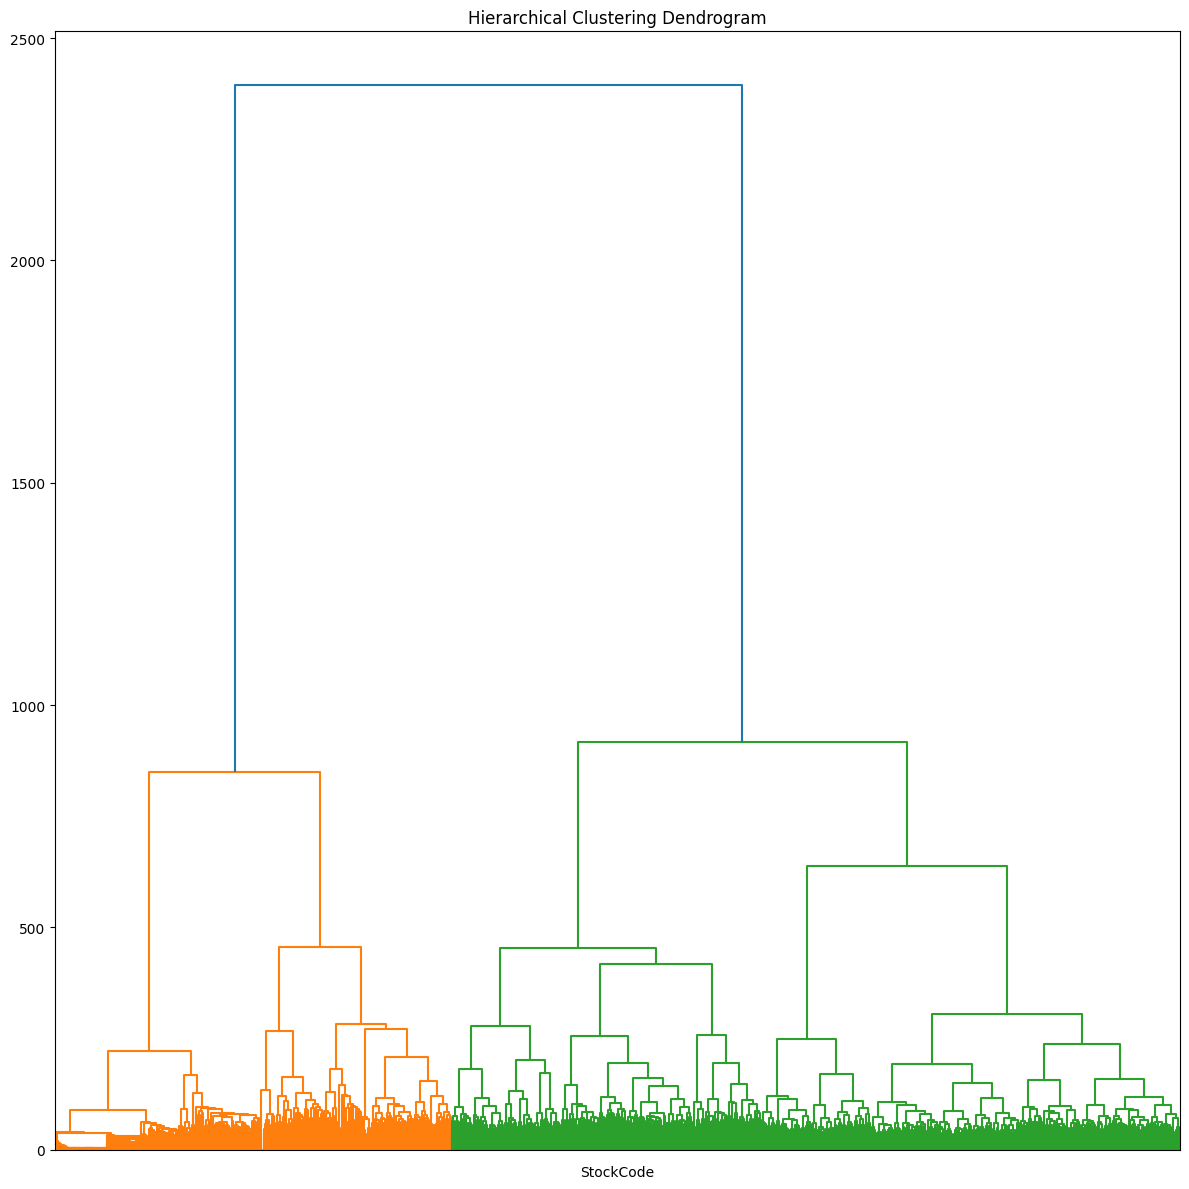

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

import matplotlib.pyplot as plt

# Perform hierarchical clustering using ward linkage
Z = linkage(transposed_df.loc[:, ~transposed_df.columns.isin(['StockCode'])], 'ward','euclidean')

# Plot the dendrogram
plt.figure(figsize=(12, 12))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('StockCode')
plt.ylabel('')
dendrogram(Z, labels=[''] * len(transposed_df.loc[:, ~transposed_df.columns.isin(['StockCode'])]))
plt.tight_layout()
plt.show()

In [ ]:
# Concatenate horizontally (merge columns)
result = pd.concat([transposed_df_copy['StockCode'], cluster_df], axis=1)


In [ ]:
result.head()

,StockCode,cluster_cluster_2,cluster_cluster_3,cluster_cluster_4,cluster_cluster_5,cluster_cluster_6,cluster_cluster_7,cluster_cluster_8,cluster_cluster_9,cluster_cluster_10
0,10002,1,3,3,3,1,1,2,2,2
1,10080,2,1,2,1,3,3,3,1,10
2,10120,2,1,2,1,3,3,3,1,3
3,10123C,2,1,4,4,4,4,8,8,8
4,10123G,2,1,4,4,4,4,8,8,8


In [ ]:
result.to_excel('Hierarchical_CLustering_Output.xlsx', index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

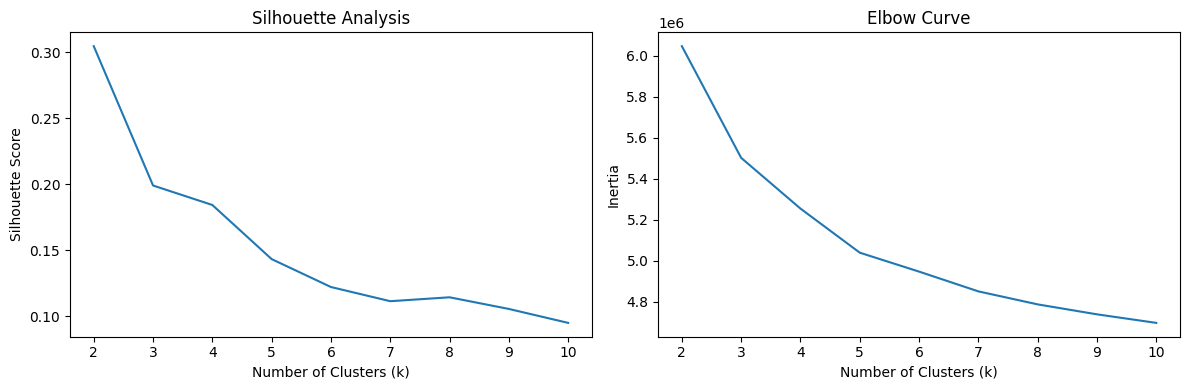

In [ ]:
### In the next steps, we will run K-means clustering and identify optimum K using Silhouette coefficient
## Subsequently, the results from k-means will be compared against hierarchichal clustering output.
# Perform silhouette analysis for different k-values
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_values = range(2, 11)
silhouette_scores = []
inertias = []

for k in k_values:
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(transposed_df.iloc[:, 1:])

    # Calculate silhouette score
    silhouette_avg = silhouette_score(transposed_df.iloc[:, 1:], labels)
    silhouette_scores.append(silhouette_avg)

    # Calculate inertia (within-cluster sum of squares)
    inertia = kmeans.inertia_
    inertias.append(inertia)
# Plot the silhouette scores and elbow curve
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot silhouette scores
ax[0].plot(k_values, silhouette_scores)
ax[0].set_xlabel('Number of Clusters (k)')
ax[0].set_ylabel('Silhouette Score')
ax[0].set_title('Silhouette Analysis')

# Plot elbow curve
ax[1].plot(k_values, inertias)
ax[1].set_xlabel('Number of Clusters (k)')
ax[1].set_ylabel('Inertia')
ax[1].set_title('Elbow Curve')

plt.tight_layout()
plt.show()


In [ ]:
silhouette_scores

[0.3045995752713543,
 0.19902155553163206,
 0.18426047643964544,
 0.14325116639407612,
 0.1221037386744074,
 0.11136303614558118,
 0.1143203673766927,
 0.10549564787787741,
 0.09493018296973373]

When there is a discrepancy between the optimal value of k suggested by the elbow method and the decreasing silhouette scores with an increasing k value, it can be challenging to determine the appropriate number of clusters. In such cases, it is important to consider additional factors and interpret the results cautiously. Here are a few possible interpretations:

1. Complex Data Structure: The dataset may have a complex structure that does not conform well to the assumptions of the k-means algorithm. The decreasing silhouette scores could indicate that the data points are not well-separated into distinct clusters or that the clusters become more overlapping as the number of clusters increases. In such cases, k-means might not be the most suitable algorithm, and alternative clustering methods or dimensionality reduction techniques could be explored.

2. Overfitting with Elbow Method: The elbow method examines the rate of decrease in inertia as the number of clusters increases. It is possible that the elbow method suggests a higher k value (e.g., 5) due to the decrease in inertia, but the silhouette scores indicate that the resulting clusters are not well-separated. This could be an indication of overfitting, where the clusters become too specific and do not capture the underlying patterns or true structure of the data.

3. Domain Knowledge and Interpretation: It is important to consider domain knowledge and interpretability of the clusters. The silhouette score is a measure of how well each sample fits its assigned cluster compared to other clusters. Even if the silhouette scores decrease, it does not necessarily mean that the clustering is meaningless or incorrect. It could be that the resulting clusters have meaningful interpretations in the context of the problem domain, despite the decrease in silhouette scores.

4. Other Evaluation Metrics: The silhouette score is one evaluation metric for clustering, but it is not the only metric available. Consider exploring other evaluation metrics, such as the Davies-Bouldin Index or the Calinski-Harabasz Index, to gain a more comprehensive understanding of the clustering performance and validate the optimal k-value.

In summary, when there is a discrepancy between the elbow method and decreasing silhouette scores, it is crucial to consider the complexity of the data, assess the interpretability of the clusters, and explore alternative evaluation metrics. Additionally, it may be worth experimenting with different clustering algorithms or techniques to identify the most appropriate way to cluster the data.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
# https://medium.com/@ugursavci/customer-segmentation-using-rfm-analysis-in-python-218a3255f714

In [12]:
df = spark.read.csv("Online Retail.csv", inferSchema=True, header = True)
df = df.toPandas()

In [13]:
def summary(df):
  display(df.head())
  print('-'*100)
  display(df.info())
  print('-'*100)
  display(df.describe([0.01,0.25,0.50,0.75,0.99]))
summary(df)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int32  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int32(1), object(5)
memory usage: 31.0+ MB


None

----------------------------------------------------------------------------------------------------


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
1%,-2.000000,0.190000,12415.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
99%,100.000000,18.000000,18212.000000
max,80995.000000,38970.000000,18287.000000


In [14]:
df['InvoiceDate1'] = pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M')
df['Date'] = df['InvoiceDate1'].dt.date

In [15]:
df['Date'].max()

datetime.date(2011, 12, 9)

In [16]:
df[df['InvoiceDate']=='2011-12-10 17:19:00']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDate1,Date


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     541909 non-null  object        
 1   StockCode     541909 non-null  object        
 2   Description   540455 non-null  object        
 3   Quantity      541909 non-null  int32         
 4   InvoiceDate   541909 non-null  object        
 5   UnitPrice     541909 non-null  float64       
 6   CustomerID    406829 non-null  float64       
 7   Country       541909 non-null  object        
 8   InvoiceDate1  541909 non-null  datetime64[ns]
 9   Date          541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int32(1), object(6)
memory usage: 39.3+ MB


In [18]:
df = df[(df.Quantity>0) & (df.UnitPrice> 0)]

In [19]:
df = df[~df['InvoiceNo'].str.startswith('C')]

In [20]:
df = df.drop_duplicates()

In [21]:
df.isnull().sum()

InvoiceNo            0
StockCode            0
Description          0
Quantity             0
InvoiceDate          0
UnitPrice            0
CustomerID      132186
Country              0
InvoiceDate1         0
Date                 0
dtype: int64

In [22]:
df.dropna(inplace=True)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392692 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     392692 non-null  object        
 1   StockCode     392692 non-null  object        
 2   Description   392692 non-null  object        
 3   Quantity      392692 non-null  int32         
 4   InvoiceDate   392692 non-null  object        
 5   UnitPrice     392692 non-null  float64       
 6   CustomerID    392692 non-null  float64       
 7   Country       392692 non-null  object        
 8   InvoiceDate1  392692 non-null  datetime64[ns]
 9   Date          392692 non-null  object        
dtypes: datetime64[ns](1), float64(2), int32(1), object(6)
memory usage: 31.5+ MB


In [24]:
df['Total_Price'] = df['UnitPrice']*df['Quantity']

In [25]:
df['Date'].max()

datetime.date(2011, 12, 9)

In [26]:
now =  dt.date(2011,12,10)

In [27]:
now

datetime.date(2011, 12, 10)

In [28]:
rfm = df.groupby('CustomerID').agg({'Date' : lambda day : (now - day.max()).days,
                               'InvoiceNo': lambda x: len(pd.unique(x)),
                              'Total_Price': lambda price : price.sum()})
col_list = ['Recency','Frequency','Monetary']
rfm.columns = col_list

In [29]:
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,3,7,4310.00
12348.0,76,4,1797.24
12349.0,19,1,1757.55
12350.0,311,1,334.40


In [30]:
rfm['Frequency'].nunique()

59

In [31]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4338 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    4338 non-null   int64  
 1   Frequency  4338 non-null   int64  
 2   Monetary   4338 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 135.6 KB


In [32]:
## Trying K-means using raw continuous variables after normalizing
## if outliers influence the clusters then we will use pentiles rather than normalized form of continuous variables
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

# Select the relevant columns for clustering
columns_for_clustering = ['Recency','Frequency','Monetary']

# Perform feature scaling on the selected columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(rfm[columns_for_clustering])

In [34]:
scaled_data

array([[ 2.32938811e+00, -4.25096503e-01,  8.36301037e+00],
       [-9.00588115e-01,  3.54416797e-01,  2.51698905e-01],
       [-1.70593488e-01, -3.53398530e-02, -2.79878269e-02],
       ...,
       [-8.50588483e-01, -2.95177619e-01, -2.08214334e-01],
       [-8.90588188e-01,  1.52368675e+00, -3.51515172e-04],
       [-5.00591059e-01, -1.65258736e-01, -2.35311112e-02]])

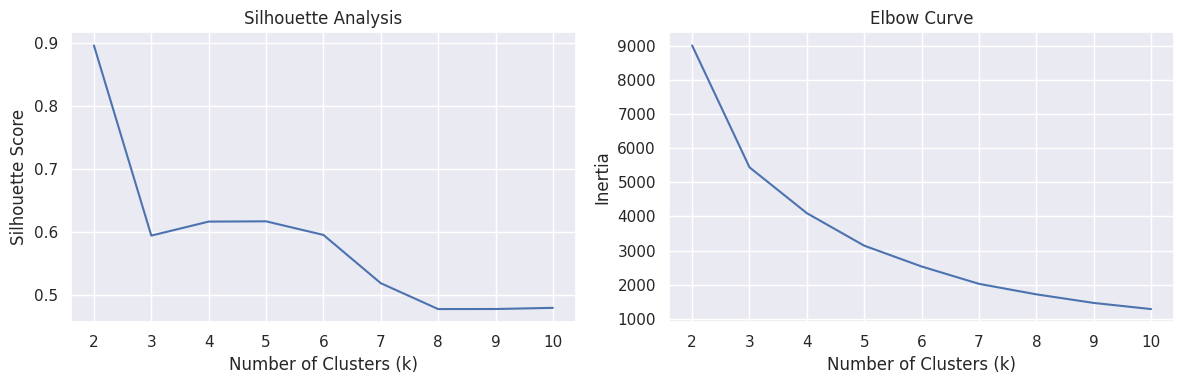

In [35]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_values = range(2, 11)
silhouette_scores = []
inertias = []

for k in k_values:
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(scaled_data)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(scaled_data, labels)
    silhouette_scores.append(silhouette_avg)

    # Calculate inertia (within-cluster sum of squares)
    inertia = kmeans.inertia_
    inertias.append(inertia)
# Plot the silhouette scores and elbow curve
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot silhouette scores
ax[0].plot(k_values, silhouette_scores)
ax[0].set_xlabel('Number of Clusters (k)')
ax[0].set_ylabel('Silhouette Score')
ax[0].set_title('Silhouette Analysis')

# Plot elbow curve
ax[1].plot(k_values, inertias)
ax[1].set_xlabel('Number of Clusters (k)')
ax[1].set_ylabel('Inertia')
ax[1].set_title('Elbow Curve')

plt.tight_layout()
plt.show()


In [36]:
## The silhouette analysis shows that 2 is the ideal no. of clusters whereas k of 3 seems ideal from elbow curve.
## Let us first examine the clustering with K= 2 and then with K= 3
kmeans = KMeans(n_clusters=2, random_state=0)
labels = kmeans.fit_predict(scaled_data)

In [37]:
rfm['labels']=labels
rfm.head()

,Recency,Frequency,Monetary,labels
CustomerID,,,,
12346.0,326,1,77183.60,0
12347.0,3,7,4310.00,0
12348.0,76,4,1797.24,0
12349.0,19,1,1757.55,0
12350.0,311,1,334.40,0


In [38]:
rfm.reset_index(inplace = True)
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4338 entries, 0 to 4337
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  4338 non-null   float64
 1   Recency     4338 non-null   int64  
 2   Frequency   4338 non-null   int64  
 3   Monetary    4338 non-null   float64
 4   labels      4338 non-null   int32  
dtypes: float64(2), int32(1), int64(2)
memory usage: 152.6 KB


In [39]:
result = rfm.groupby('labels').size().reset_index(name='count')
print(result)



   labels  count
0       0   4312
1       1     26


In [42]:
## Here we can see that the using normalized continuous variables for clustering is not yielding proper results with k= 2
## as most of the extreme points are getting clubbed into one single cluster and the alogorithm is failing to identify patterns amongst remaining points.
## Let us try with K=3 and then decide the next steps
kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(scaled_data)
rfm['labels']=labels
rfm.head()


,CustomerID,Recency,Frequency,Monetary,labels
0,12346.0,326,1,77183.60,2
1,12347.0,3,7,4310.00,1
2,12348.0,76,4,1797.24,1
3,12349.0,19,1,1757.55,1
4,12350.0,311,1,334.40,2


In [43]:
rfm.info()
result = rfm.groupby('labels').size().reset_index(name='count')
print(result)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4338 entries, 0 to 4337
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  4338 non-null   float64
 1   Recency     4338 non-null   int64  
 2   Frequency   4338 non-null   int64  
 3   Monetary    4338 non-null   float64
 4   labels      4338 non-null   int32  
dtypes: float64(2), int32(1), int64(2)
memory usage: 152.6 KB
   labels  count
0       0     26
1       1   3225
2       2   1087


In [45]:
## The outliers are still influencing the algorithm. Hence, instead of using actual continuous variables (or their normalized version), we will use corresponding
## pentiles.


In [44]:
rfm["R"] = pd.qcut(rfm["Recency"],5,labels=[5,4,3,2,1])
rfm["F"] = pd.qcut(rfm["Frequency"],5,labels=[1,2,3,4], duplicates='drop')
rfm["M"] = pd.qcut(rfm["Monetary"],5,labels=[1,2,3,4,5])
rfm["RFM_Score"] = rfm["R"].astype(str) +rfm["F"].astype(str) + rfm["M"].astype(str)

In [46]:
rfm['F'].unique()

[1, 4, 3, 2]
Categories (4, int64): [1 < 2 < 3 < 4]

In [47]:
rfm_clustering = rfm[['R','F','M']]

In [48]:
rfm_clustering

,R,F,M
0,1,1,5
1,5,4,5
2,2,3,4
3,4,1,4
4,1,1,2
...,...,...,...
4333,1,1,1
4334,1,1,1
4335,5,1,1
4336,5,4,4


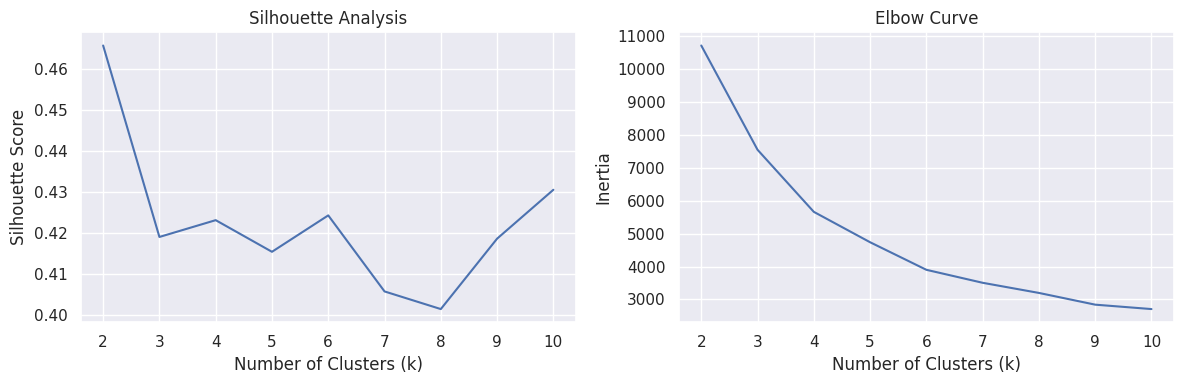

In [49]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_values = range(2, 11)
silhouette_scores = []
inertias = []

for k in k_values:
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(rfm_clustering)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(rfm_clustering, labels)
    silhouette_scores.append(silhouette_avg)

    # Calculate inertia (within-cluster sum of squares)
    inertia = kmeans.inertia_
    inertias.append(inertia)
# Plot the silhouette scores and elbow curve
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot silhouette scores
ax[0].plot(k_values, silhouette_scores)
ax[0].set_xlabel('Number of Clusters (k)')
ax[0].set_ylabel('Silhouette Score')
ax[0].set_title('Silhouette Analysis')

# Plot elbow curve
ax[1].plot(k_values, inertias)
ax[1].set_xlabel('Number of Clusters (k)')
ax[1].set_ylabel('Inertia')
ax[1].set_title('Elbow Curve')

plt.tight_layout()
plt.show()


In [50]:
kmeans = KMeans(n_clusters=4, random_state=0)
labels = kmeans.fit_predict(rfm_clustering)

In [51]:

rfm['Cluster'] = labels


In [ ]:
rfm.to_excel('Customer_Segmentation_K_means.xlsx', index=False)

Epsilon = 0.02
Cluster Labels: [-1  0 -1 ... -1 -1 -1]
Silhouette Score: 0.022135996017820556
-------------------
Epsilon = 0.03
Cluster Labels: [-1  0 -1 ... -1 -1 -1]
Silhouette Score: 0.022135996017820556
-------------------
Epsilon = 0.04
Cluster Labels: [-1  0 -1 ... -1 -1 -1]
Silhouette Score: 0.022135996017820556
-------------------
Epsilon = 0.05
Cluster Labels: [-1  0 -1 ... -1 -1 -1]
Silhouette Score: 0.022135996017820556
-------------------
Epsilon = 0.06
Cluster Labels: [-1  0 -1 ... -1 -1 -1]
Silhouette Score: 0.022135996017820556
-------------------
Epsilon = 0.07
Cluster Labels: [-1  0 -1 ... -1 -1 -1]
Silhouette Score: 0.022135996017820556
-------------------
Epsilon = 0.08
Cluster Labels: [-1  0 -1 ... -1 -1 -1]
Silhouette Score: 0.022135996017820556
-------------------
Epsilon = 0.09
Cluster Labels: [-1  0 -1 ... -1 -1 -1]
Silhouette Score: 0.022135996017820556
-------------------
Epsilon = 0.1
Cluster Labels: [-1  0 -1 ... -1 -1 -1]
Silhouette Score: 0.02213599601782

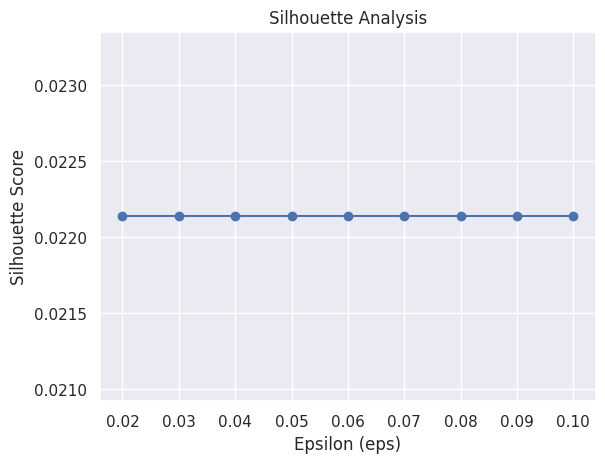

In [52]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Fixed min_samples value
min_samples = 300

# List of epsilon values to try
eps_values = [0.02, 0.03, 0.04, 0.05, 0.06,0.07,0.08,0.09,0.1]

# Perform DBSCAN clustering with different epsilon values
silhouette_scores = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(rfm_clustering)
    silhouette_avg = silhouette_score(rfm_clustering, labels)
    silhouette_scores.append(silhouette_avg)

    print("Epsilon =", eps)
    print("Cluster Labels:", labels)
    print("Silhouette Score:", silhouette_avg)
    print("-------------------")

# Plotting the silhouette scores
plt.plot(eps_values, silhouette_scores, marker='o')
plt.xlabel('Epsilon (eps)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()


In [53]:
np.unique(labels)

array([-1,  0,  1])

In [54]:
## Testing the cluster size with epsilon= 0.02 and min_samples=300
dbscan = DBSCAN(eps=0.02, min_samples=300)
labels = dbscan.fit_predict(rfm_clustering)

In [55]:
rfm_clustering

,R,F,M
0,1,1,5
1,5,4,5
2,2,3,4
3,4,1,4
4,1,1,2
...,...,...,...
4333,1,1,1
4334,1,1,1
4335,5,1,1
4336,5,4,4


In [56]:
rfm_clustering['Customer_ID']=rfm['CustomerID']
rfm_clustering['dbscan_labels']=labels

In [57]:
result = rfm_clustering.groupby('dbscan_labels').size().reset_index(name='count')
print(result)

   dbscan_labels  count
0             -1   3659
1              0    323
2              1    356


In [ ]:
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Loose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [ ]:
len(df)

388538

In [ ]:
rfm['Segment'] = rfm['R'].astype(str) + rfm['F'].astype(str)
rfm['Segment'] = rfm['Segment'].replace(seg_map, regex=True)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Score,Segment
CustomerID,,,,,,,,
12346.0,325,1,77183.60,1,1,5,115,Hibernating
12347.0,2,179,4256.90,5,5,5,555,Champions
12348.0,75,31,1797.24,2,3,4,234,At Risk
12349.0,18,73,1757.55,4,4,4,444,Loyal Customers
12350.0,310,15,306.50,1,2,2,122,Hibernating


In [ ]:
rfm.reset_index(inplace=True)

In [ ]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Score,Segment
0,12346.0,325,1,77183.60,1,1,5,115,Hibernating
1,12347.0,2,179,4256.90,5,5,5,555,Champions
2,12348.0,75,31,1797.24,2,3,4,234,At Risk
3,12349.0,18,73,1757.55,4,4,4,444,Loyal Customers
4,12350.0,310,15,306.50,1,2,2,122,Hibernating


In [ ]:
len(rfm)

4333

In [ ]:
rfm.groupby('Segment').mean().sort_values('Monetary')


,Recency,Frequency,Monetary
Segment,,,
Promising,22.888889,7.777778,418.106481
About to Sleep,52.134969,15.947853,448.272638
Hibernating,209.496317,13.659300,531.554725
Need Attention,51.975490,41.225490,821.920392
Potential Loyalists,15.643145,34.723790,897.880022
At Risk,163.561151,56.625899,1000.168022
Can't Loose,144.851852,177.493827,2379.549889
Loyal Customers,33.696587,153.356511,2813.549494
New Customers,7.047619,7.650794,3352.233333


In [ ]:
merged_df = pd.merge(df, rfm, on='CustomerID', how='right')

In [ ]:
merged_df = merged_df.drop_duplicates(subset='CustomerID')

In [ ]:
merged_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Price,Recency,Frequency,Monetary,R,F,M,RFM_Score,Segment
0,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.6,325,1,77183.60,1,1,5,115,Hibernating
1,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,2010-12-07 14:57:00,2.10,12347.0,Iceland,25.2,2,179,4256.90,5,5,5,555,Champions
180,539318,84992,72 SWEETHEART FAIRY CAKE CASES,72,2010-12-16 19:09:00,0.55,12348.0,Finland,39.6,75,31,1797.24,2,3,4,234,At Risk
211,577609,23112,PARISIENNE CURIO CABINET,2,2011-11-21 09:51:00,7.50,12349.0,Italy,15.0,18,73,1757.55,4,4,4,444,Loyal Customers
284,543037,21908,CHOCOLATE THIS WAY METAL SIGN,12,2011-02-02 16:01:00,2.10,12350.0,Norway,25.2,310,15,306.50,1,2,2,122,Hibernating


In [ ]:
!pip install kmodes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from kmodes.kprototypes import KPrototypes

In [ ]:
merged_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Price,Recency,Frequency,Monetary,R,F,M,RFM_Score,Segment
0,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.6,325,1,77183.60,1,1,5,115,Hibernating
1,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,2010-12-07 14:57:00,2.10,12347.0,Iceland,25.2,2,179,4256.90,5,5,5,555,Champions
180,539318,84992,72 SWEETHEART FAIRY CAKE CASES,72,2010-12-16 19:09:00,0.55,12348.0,Finland,39.6,75,31,1797.24,2,3,4,234,At Risk
211,577609,23112,PARISIENNE CURIO CABINET,2,2011-11-21 09:51:00,7.50,12349.0,Italy,15.0,18,73,1757.55,4,4,4,444,Loyal Customers
284,543037,21908,CHOCOLATE THIS WAY METAL SIGN,12,2011-02-02 16:01:00,2.10,12350.0,Norway,25.2,310,15,306.50,1,2,2,122,Hibernating


In [ ]:
# Select the columns for clustering (both numerical and categorical)
# Select the columns for clustering
from sklearn.preprocessing import OneHotEncoder

columns_for_clustering = ['Quantity', 'UnitPrice', 'Total_Price', 'Recency', 'Frequency', 'Monetary', 'R', 'F', 'M']

# Perform one-hot encoding on categorical variables
categorical_cols = ['Country', 'Segment']
enc = OneHotEncoder(sparse=False)
encoded_categorical = enc.fit_transform(merged_df[categorical_cols])

# Concatenate numerical and encoded categorical variables
X = np.concatenate((merged_df[columns_for_clustering].values, encoded_categorical), axis=1)

# Specify the number of clusters
n_clusters = 3

# Run k-prototype algorithm
kproto = KPrototypes(n_clusters=n_clusters, init='Cao', random_state=42)
clusters = kproto.fit_predict(X, categorical=[9, 10])  # Index 9 corresponds to the 'Segment' column


In [ ]:
# Add the cluster labels to the original dataframe
merged_df['Cluster'] = clusters

In [ ]:
merged_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Price,Recency,Frequency,Monetary,R,F,M,RFM_Score,Segment,Cluster
0,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.6,325,1,77183.60,1,1,5,115,Hibernating,2
1,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,2010-12-07 14:57:00,2.10,12347.0,Iceland,25.2,2,179,4256.90,5,5,5,555,Champions,1
180,539318,84992,72 SWEETHEART FAIRY CAKE CASES,72,2010-12-16 19:09:00,0.55,12348.0,Finland,39.6,75,31,1797.24,2,3,4,234,At Risk,1
211,577609,23112,PARISIENNE CURIO CABINET,2,2011-11-21 09:51:00,7.50,12349.0,Italy,15.0,18,73,1757.55,4,4,4,444,Loyal Customers,1
284,543037,21908,CHOCOLATE THIS WAY METAL SIGN,12,2011-02-02 16:01:00,2.10,12350.0,Norway,25.2,310,15,306.50,1,2,2,122,Hibernating,1


In [ ]:
merged_df.to_csv('k-prototype_output.csv', index = False)
from google.colab import files
files.download("k-prototype_output.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

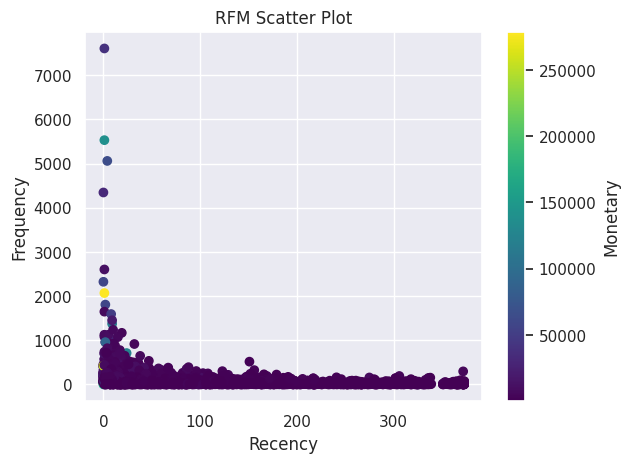

In [ ]:
plt.scatter(merged_df['Recency'], merged_df['Frequency'], c=merged_df['Monetary'], cmap='viridis')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('RFM Scatter Plot')
plt.colorbar(label='Monetary')
plt.show()

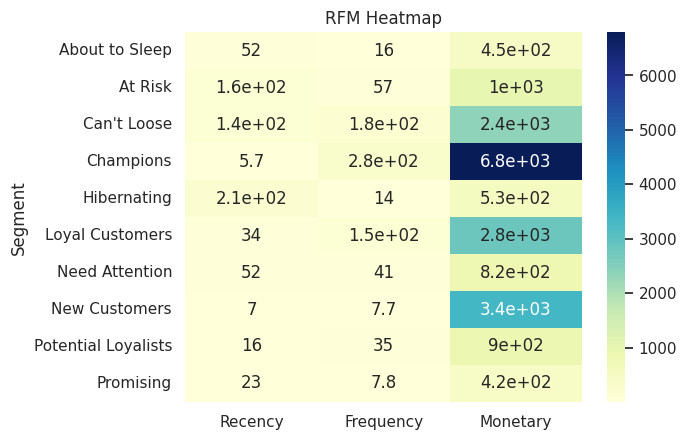

In [ ]:
rfm_avg = merged_df.groupby('Segment')['Recency', 'Frequency', 'Monetary'].mean()
sns.heatmap(rfm_avg, annot=True, cmap='YlGnBu')
plt.title('RFM Heatmap')
plt.show()

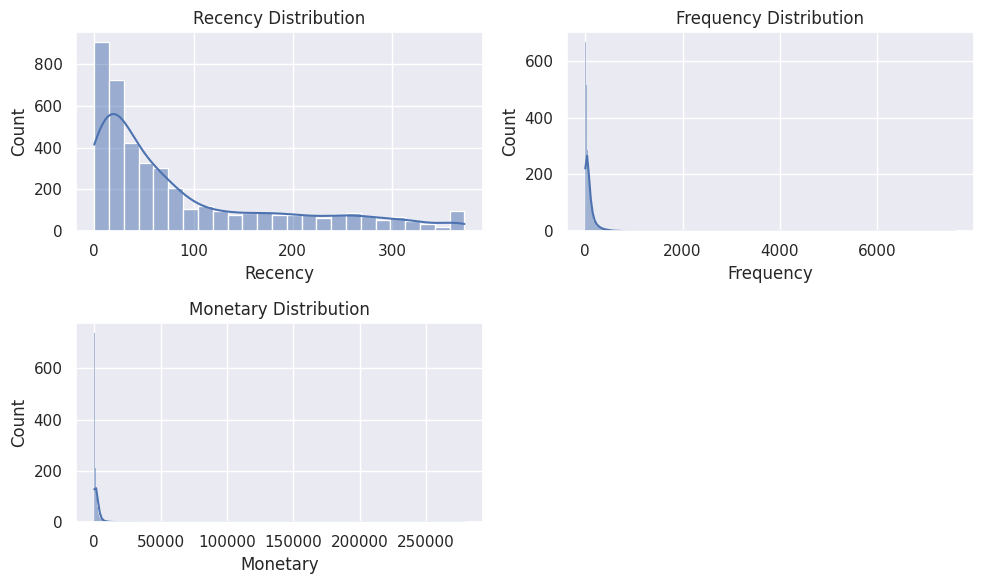

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
sns.histplot(merged_df['Recency'], kde=True)
plt.title('Recency Distribution')

plt.subplot(2, 2, 2)
sns.histplot(merged_df['Frequency'], kde=True)
plt.title('Frequency Distribution')

plt.subplot(2, 2, 3)
sns.histplot(merged_df['Monetary'], kde=True)
plt.title('Monetary Distribution')

plt.tight_layout()
plt.show()

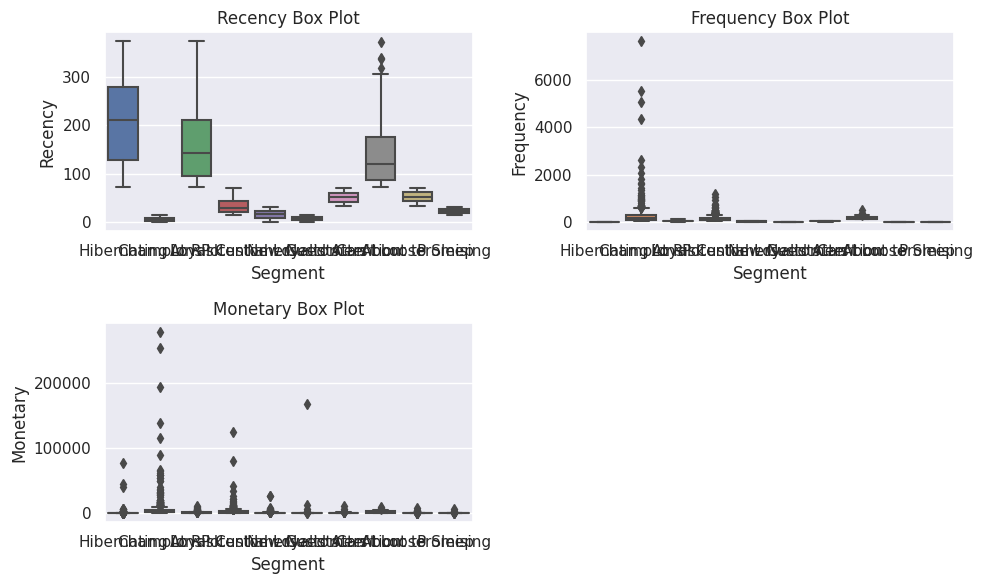

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
sns.boxplot(x=merged_df['Segment'], y=merged_df['Recency'])
plt.title('Recency Box Plot')

plt.subplot(2, 2, 2)
sns.boxplot(x=merged_df['Segment'], y=merged_df['Frequency'])
plt.title('Frequency Box Plot')

plt.subplot(2, 2, 3)
sns.boxplot(x=merged_df['Segment'], y=merged_df['Monetary'])
plt.title('Monetary Box Plot')

plt.tight_layout()
plt.show()